In [3]:
# getting the library that has some of the functions needed for simulations
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import time
from numba import njit, prange
import pandas as pd

%matplotlib inline

In [4]:
@jit(nopython=True)
def cdf_inv_fr(u, gamma):
  return ((pow(-np.log(u) , -gamma)))

@jit(nopython=True)
def cdf_inv_H(u , gamma, beta):
  return (pow(-np.log(u)/(pow(beta , -1/gamma)-1) , -gamma) )

@jit(nopython=True)
def armax(beta , gamma, n):
  x = np.zeros(n)
  #r = np.random.RandomState(random_state)
  u = np.random.uniform(0,1,1)[0]
  x0 = cdf_inv_fr(u,gamma)
  xi_lag = x0
  x[0] = x0
  #print(x0)
  t = 1
  for i in range(n-1):
    #r2 = np.random.RandomState(random_state + i)
    u = np.random.uniform(0,1,1)[0]
    zi = cdf_inv_H(u,gamma,beta)
    xi = beta*max(xi_lag , zi)
    xi_lag = xi
    x[t] = xi
    t = t + 1
    #print(zi)
  return x

In [5]:
@jit(nopython=True)
def theta_n_k(X, n, k_=1):
  sum = 0
  k = int(k_)

  X_k = np.partition(X, n-k-1)[n-k-1]
  #if k <= 1:
  # return 1

  #X_k = max(X[n-k:n])
  
  for j in range(n-1):
    # k-th top order equals n-k low order
    if X[j] <= X_k and X[j+1] > X_k:
      sum += 1

  if k == 0:
    return 1

  #if sum/k >= 1:
  #  return 1
  return sum/k


@jit(nopython=True)
def theta_GJ_k(X, n, k, delta):
  #n = X.shape[0]

  numerator = (delta*delta + 1) * theta_n_k(X,n, int(np.floor(delta*k)) + 1) - delta*(theta_n_k(X, n, int(np.floor(delta*delta*k)) + 1) + theta_n_k(X, n, k))
  denominator = (1 - delta)**2

  if numerator < 0: 
    return 0

  #return (numerator/denominator if numerator/denominator <= 1 else 1)
  return numerator/denominator

In [6]:
@jit(nopython = True)
def np_apply_along_axis(func1d, axis, arr):
  assert arr.ndim == 2
  assert axis in [0, 1]
  if axis == 0:
    result = np.empty(arr.shape[1])
    for i in range(len(result)):
      result[i] = func1d(arr[:, i])
  else:
    result = np.empty(arr.shape[0])
    for i in range(len(result)):
      result[i] = func1d(arr[i, :])
  return result

In [7]:
@jit(nopython=True)
def simulate_mean_mse(n, theta, runs = 15, replicates = 10):
  all_values_mean = np.zeros(n)
  all_values_mse = np.zeros(n)

  #print("Theta_N", end = "")
  for run in range(runs):
    #print("\nrun = ", run + 1, "/", runs ,"...", sep = "", end = " ")
    a = np.zeros((replicates, n))
    for i in range(replicates):
      a[i] = armax(1-theta, 1, n)
  
    path = np.zeros((replicates, n))
    path2 = np.zeros((replicates, n))

    k_range = list(range(n))

    for k in k_range:
      #if k%100 == 0:
      #  print(int(k/100) + 1, end = " ")
      for j in range(replicates):
        path[j][k] = theta_n_k(a[j], n, k)
        path2[j][k] = (path[j][k] - theta)**2

    #one_run_mean = np.mean(path, axis = 0)
  
    all_values_mean += np_apply_along_axis(np.mean, 0, path)
    all_values_mse += np_apply_along_axis(np.mean, 0, path2)

  return all_values_mean/runs, all_values_mse/runs

In [8]:
@jit(nopython=True)
def simulate_mean_mse_GJ(n, theta, delta = 0.25, runs = 15, replicates = 10):
  all_values_mean = np.zeros(n)
  all_values_mse = np.zeros(n)

  #print("Theta_N", end = "")
  for run in range(runs):
    #print("\nrun = ", run + 1, "/", runs ,"...", sep = "", end = " ")
    a = np.zeros((replicates, n))
    for i in range(replicates):
      a[i] = armax(1-theta, 1, n)
  
    path = np.zeros((replicates, n))
    path2 = np.zeros((replicates, n))

    k_range = list(range(n))

    for k in k_range:
      #if k%100 == 0:
      #  print(int(k/100) + 1, end = " ")
      for j in range(replicates):
        path[j][k] = theta_GJ_k(a[j], n, k, delta)
        path2[j][k] = (path[j][k] - theta)**2

    #one_run_mean = np.mean(path, axis = 0)
  
  all_values_mean += np_apply_along_axis(np.mean, 0, path)
  all_values_mse += np_apply_along_axis(np.mean, 0, path2)

  return all_values_mean/runs, all_values_mse/runs

In [9]:
@njit
def subsampling_GJ(X, n, theta, T = 2, delta = 0.25):
  r = int(np.floor(n/T))

  theta_Vi = np.zeros((T, r))

  #X = armax(1- theta, 1, n)

  for i in range(T):
    V = X[i:(r-1)*T+i+1:T]

    for j in range(1, r):
      theta_Vi[i][j] = theta_GJ_k(V, V.shape[0], j, delta)

  theta_sub = -1 * np.ones(n)  

  for j in range(1, r):
    #temp = 1 - np.power(abs(1 - theta_Vi[:,j]), 1/T).mean(axis = 0)
    theta_sub[(j - 1)*T + 1] = 1 - ((np.power(1 - theta_Vi[:,j], 1/T)).mean())
    theta_sub[np.isnan(theta_sub)] = 0
  
  for k in range(1, n):
    if theta_sub[k] == -1:
      theta_sub[k] = theta_sub[k-1]

  return theta_sub

In [10]:
@njit
def simulate_mean_mse_GJ_sub(n, T = 2, theta = 0.2, delta = 0.25, replicates = 10, runs = 15):
  all_values_mean = np.zeros(n)
  all_values_mse = np.zeros(n)

  for run in range(runs):
    #print("\nrun = ", run + 1, "/", runs ,"...", sep = "", end = " ")
    a = np.zeros((replicates, n))
    for i in range(replicates):
      a[i] = armax(1-theta, 1, n)
  
    path = np.zeros((replicates, n))
    path2 = np.zeros((replicates, n))

    k_range = list(range(n))

    
    for j in range(replicates):
      path[j] = subsampling_GJ(a[j], n, theta, T, delta)
      path2[j] = np.power((path[j] - theta), 2)

    #one_run_mean = np.mean(path, axis = 0)
  
    all_values_mean += np_apply_along_axis(np.mean, 0, path)
    all_values_mse += np_apply_along_axis(np.mean, 0, path2)

  return all_values_mean/runs, all_values_mse/runs

In [10]:
%%time
e, m = simulate_mean_mse_GJ_sub(5000)

Wall time: 2min 26s


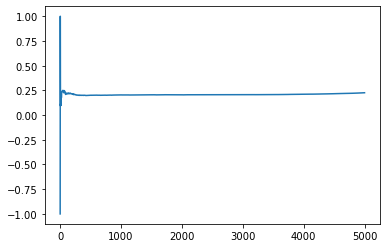

In [11]:
plt.plot(e)

In [11]:
%%time
runs = 100
replicates = 10
n = 5000
theta = 0.2
delta = 0.25
e_1000_5, mse_1000_5 = simulate_mean_mse(n, theta, runs = runs, replicates = replicates)
e_1000_5_1, mse_1000_5_1 = simulate_mean_mse_GJ(n, theta, delta, runs = runs, replicates = replicates)
e_1000_5_2, mse_1000_5_2 = simulate_mean_mse_GJ_sub(n, 2, theta, delta, replicates, runs)

Wall time: 1h 52s


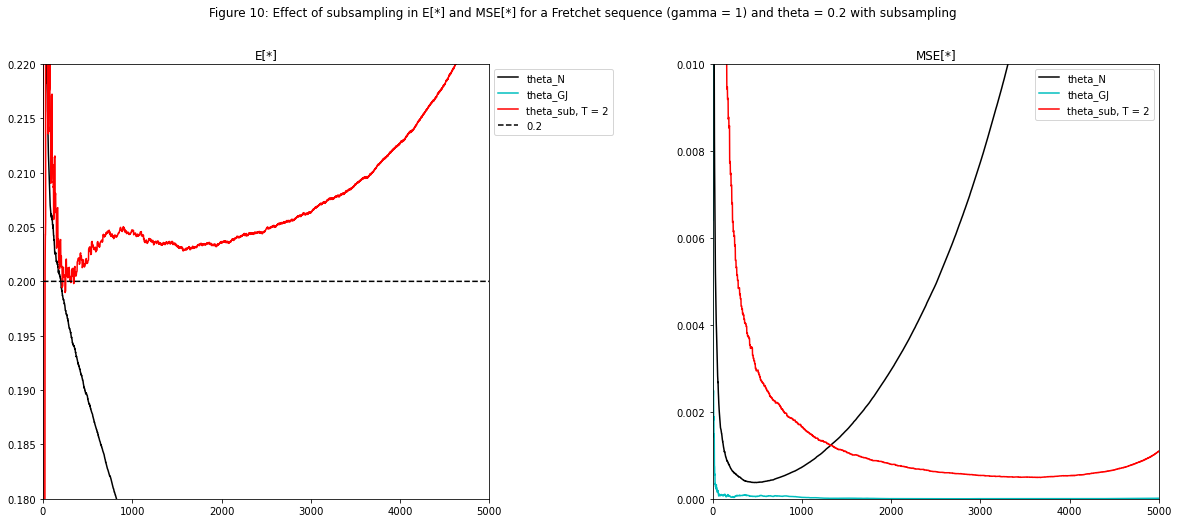

In [17]:
# plotting
alph = 0.5
straight_line = theta*np.ones(n)
k_range = np.arange(n)
fig, axs = plt.subplots(1, 2, figsize = (20,8))

fig.suptitle("Figure 10: Effect of subsampling in E[*] and MSE[*] for a Fretchet sequence (gamma = 1) and theta = " + str(theta) + " with subsampling")
axs[0].set_ylim([0.18, 0.22])
axs[0].set_xlim([0,n])
axs[0].set_title("E[*]")
axs[0].plot(k_range, e_1000_5, 'k-', label = 'theta_N')
axs[0].plot(k_range, e_1000_5_1, 'c-', label = 'theta_GJ')
axs[0].plot(k_range, e_1000_5_2, 'r-', label = 'theta_sub, T = 2')
axs[0].plot(k_range, straight_line, 'k--', label = str(theta))
axs[0].legend(bbox_to_anchor=(1, 1))


axs[1].set_ylim([0, 0.01])
axs[1].set_xlim([0,n])
axs[1].set_title("MSE[*]")
axs[1].plot(k_range, mse_1000_5, 'k-', label = 'theta_N')
axs[1].plot(k_range, mse_1000_5_1, 'c-', label = 'theta_GJ')
axs[1].plot(k_range, mse_1000_5_2, 'r-', label = 'theta_sub, T = 2')

axs[1].legend(bbox_to_anchor=(1, 1))

fig.subplots_adjust(wspace=0.5)

In [13]:
e_1000_5_1

array([0.01      , 0.01      , 0.01177778, ..., 0.00229393, 0.00229455,
       0.00229527])